# ANÁLISIS ESTÁTICO

Notebook de análisis estático de pórticos de albañilería confinada

## Definiciones previas

In [1]:
pip install openseespy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install opsvis

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: opsvis in c:\users\gusta\appdata\local\programs\python\python38\lib\site-packages (1.1.5)




[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Unidades Base
m = 1
kg = 1
s = 1
# Constantes Físicas
g = 9.80665*m/s**2
# Otras Unidades
cm = 0.01*m
N = kg*m/s**2
kN = 1000*N
kgf = g*N
tonf = 1000*kgf
Pa = N/m**2


In [4]:
# PROPIEDADES DE MATERIALES Y SECCIONES
# fc = 210*kgf/cm**2
# E = 15100*(fc/(kgf/cm**2))**0.5*kgf/cm**2
# G = 0.5*E/(1+0.2)

fy = 4200*kgf/cm**2  # Fluencia del acero
Es = 2.1*10**6*kgf/cm**2  # Módulo de elasticidad del acero
fc = 210  # kg/cm2             #Resistencia a la compresión del concreto
E = 15100*fc**0.5*kgf/cm**2  # Módulo de elasticidad del concreto
G = 0.5*E/(1+0.2)  # Módulo de corte del concreto
fc = fc*kgf/cm**2
cover = 4*cm  # Recubrimiento de vigas y columnas

# Parametros no lineales de comportamiento del concreto
fc1 = -fc  # Resistencia a la compresión del concreto
Ec1 = E  # Módulo de elasticidad del concreto
nuc1 = 0.2  # Coeficiente de Poisson
Gc1 = Ec1/(2*(1+nuc1))  # Módulo de corte del concreto

# Concreto confinado
Kfc = 1.0  # 1.3               # ratio of confined to unconfined concrete strength
Kres = 0.2                    # ratio of residual/ultimate to maximum stress
fpc1 = Kfc*fc1
epsc01 = 2*fpc1/Ec1
fpcu1 = Kres*fpc1
epsU1 = 5*epsc01  # 20
lambda1 = 0.1
# Concreto no confinado
fpc2 = fc1
epsc02 = -0.003
fpcu2 = Kres*fpc2
epsU2 = -0.006  # -0.01
# Propiedades de resistencia a la tracción
ft1 = -0.14*fpc1
ft2 = -0.14*fpc2
Ets = ft2/0.002
#print(E/10**8, Ets/10**8)

# Densidad del concreto
ρ = 2400*kg/m**3


def prop_vig(bv, hv):

    Av = bv*hv
    ρlv = 2400*Av*m**2  # Densidad lineal de la viga
    Izv = hv**3*bv/12
    Iyv = hv*bv**3/12
    k = 1/3-0.21*bv/hv*(1-(bv/hv)**4/12)
    Jv = k*bv**3*hv
    return Av, ρlv, Izv, Iyv, k, Jv


def prop_col(bc, hc):

    Ac = bc*hc
    ρlc = 2400*Ac*m**2  # Densidad lineal de la columna
    Izc = hc**3*bc/12
    Iyc = hc*bc**3/12
    k = 1/3-0.21*bc/hc*(1-(bc/hc)**4/12)
    Jc = k*bc**3*hc
    return Ac, ρlc, Izc, Iyc, k, Jc

def distancia(P1:float=[], P2:float=[]):
    Sumacuadra=0
    for item in range(len(P1)):
         Sumacuadra=Sumacuadra+(P1[item]-P2[item])**2
    return Sumacuadra**0.5

# Aplicando Cargas vivas y muertas
wLive = 250*kg/m**2
wLosa = 300*kg/m**2
wAcab = 100*kg/m**2
wTabi = 150*kg/m**2
wTotal = 1.0*(wLosa+wAcab+wTabi)+0.25*wLive

aPlanta = 321

In [5]:
class material:
  def __init__(self, tipo:str='Elastic', tag:int=1, caracteristicas:float=[E]):
     self.tipo=tipo
     self.tag=tag
     self.caracteristicas=caracteristicas
def MediaCoordenada(arreglo:float=[]):
   x=0
   y=0
   z=0
   total=len(arreglo)
   for item in range(total):
      Nudo=arreglo[item]
      x=x+Nudo[0]
      y=y+Nudo[1]
      z=z+Nudo[2]
   return [x/total,y/total,z/total]

def EyGdeFc(fc:float=210):
   Edfc=15100*210**0.5*kgf/cm**2
   Gdfc=0.5*Edfc/(1+0.2)
   return [Edfc,Gdfc]

In [6]:
from openseespy.opensees import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
import opsvis as opsv

## Definiciones de malla

### Definición de grilla

Text(0.5, 0, 'z')

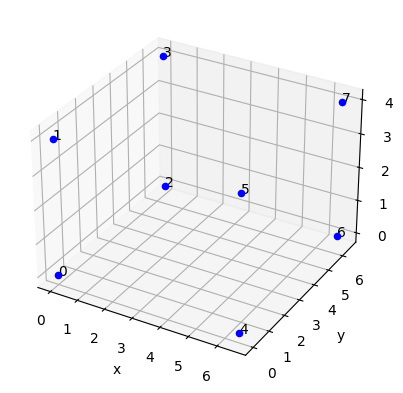

In [7]:
##Malla Global
####Definición de Malla
Span_X=6.5
Span_Y=6.5
Storey_Z=4

Grillas_X=2
Grillas_Y=2
Grillas_Z=2

####Generación de Malla
Absolutas_x=[]
Absolutas_y=[]
Absolutas_z=[]
Nodos=[]

for item in range(Grillas_X):
  Absolutas_x.append(0+item*Span_X)
for item in range(Grillas_Y):
  Absolutas_y.append(0+item*Span_Y)
for item in range(Grillas_Z):
  Absolutas_z.append(0+item*Storey_Z)

for x,y,z in itertools.product(Absolutas_x,Absolutas_y,Absolutas_z):
  Nodos.append([x,y,z])

#####Imprimimos la malla
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for item in range(len(Nodos)):
  Nodo=Nodos[item]
  x=Nodo[0]
  y=Nodo[1]
  z=Nodo[2]


  ax.scatter(x,y,z,color='b')
  ax.text(x,y,z,  '%s' % (item), size=10, zorder=1,color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(30,30,0)
#ax.view_init(30,30,0)

Text(0.5, 0, 'z')

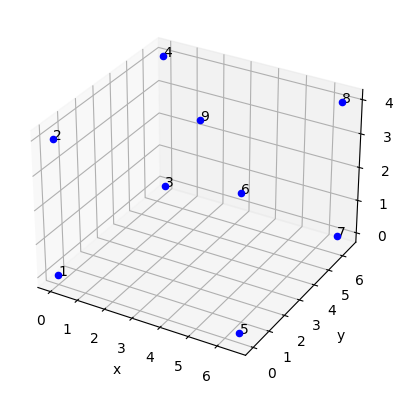

In [8]:
####Puntos adicionales en caso de ser necesario

Nodos.append(MediaCoordenada([Nodos[1],Nodos[3],Nodos[5],Nodos[7]]))
#####Imprimimos la malla
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for item in range(len(Nodos)):
  Nodo=Nodos[item]
  x=Nodo[0]
  y=Nodo[1]
  z=Nodo[2]


  ax.scatter(x,y,z,color='b')
  ax.text(x,y,z,  '%s' % (item+1), size=10, zorder=1,color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(30,30,0)
#ax.view_init(30,30,0)

### Empotramientos y Diafragmas

In [9]:
#Empotramientos y diafragmas
PuntosFijos=[1,3,5,7]
DiafragmaRigido=[[9,[2,4,6,8]]]

## Definición de materiales

In [10]:
#Definición de materiales con una clase personalizada
#https://opensees.berkeley.edu/wiki/index.php/UniaxialMaterial_Command
#https://openseespydoc.readthedocs.io/en/latest/src/uniaxialMaterial.html
EyG210=EyGdeFc(210)
Concreto210=material('Elastic',1,[EyG210[0]])
print(EyG210)

[21458890824.97081, 8941204510.404505]


## Características de los elementos

In [12]:

#Variaciones de peralte $Base, $PeralteInicial, $PeralteFinal, $Muestreos
DcInicial=0.25
DcFinal=0.65
Saltosc=3
CaractColumnasTipo1=[0.25,DcInicial,DcFinal,Saltosc]
CaractColumnasTipo2=[0.25,DcInicial,DcFinal,Saltosc]
CaractColumnasTipo3=[0.25,DcInicial,DcFinal,Saltosc]
CaractColumnasTipo4=[0.25,DcInicial,DcFinal,Saltosc]
DvInicial=0.20
DvFinal=0.60
Saltosv=3
CaractVigasTipo1=[0.25,DvInicial,DvFinal,Saltosv]
CaractVigasTipo2=[0.25,DvInicial,DvFinal,Saltosv]
CaractVigasTipo3=[0.25,DvInicial,DvFinal,Saltosv]
CaractVigasTipo4=[0.25,DvInicial,DvFinal,Saltosv]

#Elementos lineales
ColumnasTipo1=[[[1,2],CaractColumnasTipo1,EyG210]]
ColumnasTipo2=[[[3,4],CaractColumnasTipo2,EyG210]]
ColumnasTipo3=[[[7,8],CaractColumnasTipo3,EyG210]]
ColumnasTipo4=[[[5,6],CaractColumnasTipo4,EyG210]]
VigasTipo1=[[[2,4],CaractVigasTipo1,EyG210]]
VigasTipo2=[[[4,8],CaractVigasTipo2,EyG210]]
VigasTipo3=[[[6,8],CaractVigasTipo3,EyG210]]
VigasTipo4=[[[2,6],CaractVigasTipo4,EyG210]]

#Elementos shell
LosaTipo1=[[2,4,8,6]]

NumeroDeIteracionesParaMalla=CaractColumnasTipo1[3]*CaractColumnasTipo2[3]*CaractColumnasTipo3[3]*CaractColumnasTipo4[3]*CaractVigasTipo1[3]*CaractVigasTipo2[3]*CaractVigasTipo3[3]*CaractVigasTipo4[3]
print(NumeroDeIteracionesParaMalla)

6561


## Calculo de factores de ampliación y reducción sísmica

In [13]:
#Factores de amplificación y reducción sísmica
def switchZ(Ztype):
    if Ztype == 1:
        return 0.1
    elif Ztype == 2:
        return 0.25
    elif Ztype == 3:
        return 0.35
    elif Ztype == 4:
        return 0.45
def switchS(Stype,Ztype):
    if Stype == 1:
        Svalue=[0.80,0.80,0.80,0.80]
        Tp,Tl=0.3,3.0
        return Svalue[Ztype-1],Tp,Tl
    elif Stype == 2:
        Svalue=[1,1,1,1]
        Tp,Tl=0.4,2.5
        return Svalue[Ztype-1],Tp,Tl
    elif Stype == 3:
        Svalue=[1.60,1.20,1.15,1.05]
        Tp,Tl=0.6,2.0
        return Svalue[Ztype-1],Tp,Tl
    elif Stype == 4:
        Svalue=[0.80,0.80,0.80,0.80]
        Tp,Tl=1.0,1.6
        return Svalue[Ztype-1],Tp,Tl
def switchU(Utype):
    if Utype == "A":
        return 1.5
    elif Utype == "B":
        return 1.3
    elif Utype == "C":
        return 1.0

def switchR(Rtype):
    if Rtype == "Pórticos":
        return 8
    elif Rtype == "Dual":
        return 7
    elif Rtype == "Muros Estructurales":
        return 6
    elif Rtype == "MDL": #Muros de ductilidad limitada
        return 4
    elif Rtype == "Albañilería": #Muros de ductilidad limitada
        return 3
#Factores estáticos
Zfactor=switchZ(4)
Sfactor,Tp,tl=switchS(3,4)
Ufactor=switchU("C")
Rxfactor=switchR("Pórticos")
Ryfactor=switchR("Pórticos")

In [14]:
#Análisis estático
def switchCt(Cttype):
    if Cttype == 1:
        return 35
    elif Cttype == 2:
        return 45
    elif Cttype == 3:
        return 60
#direccionX
Ctxfactor=switchCt(1)
Txfactor=max(Absolutas_z)/Ctxfactor

Cxfactor=round(Tp/Txfactor,3)
if (Cxfactor/Rxfactor)<0.11:
    Cxfactor=0.11*Rxfactor


#direccionY
Ctyfactor=switchCt(1)
Tyfactor=max(Absolutas_z)/Ctyfactor

Cyfactor=round(Tp/Tyfactor,3)
if (Cyfactor/Ryfactor)<0.11:
    Cyfactor=0.11*Ryfactor

print(Zfactor,Sfactor,Ufactor,Tp,tl,Rxfactor,Ryfactor,Cxfactor,Cyfactor)

0.45 1.05 1.0 0.6 2.0 8 8 5.25 5.25


## Análisis en openseespy

In [15]:
bc1=CaractColumnasTipo1[0]
bc2=CaractColumnasTipo2[0]
bc3=CaractColumnasTipo3[0]
bc4=CaractColumnasTipo4[0]

bv1=CaractVigasTipo1[0]
bv2=CaractVigasTipo2[0]
bv3=CaractVigasTipo3[0]
bv4=CaractVigasTipo4[0]

PeraltesColumnas1=np.linspace(CaractColumnasTipo1[1],CaractColumnasTipo1[2],CaractColumnasTipo1[3])
PeraltesColumnas2=np.linspace(CaractColumnasTipo2[1],CaractColumnasTipo2[2],CaractColumnasTipo2[3])
PeraltesColumnas3=np.linspace(CaractColumnasTipo3[1],CaractColumnasTipo3[2],CaractColumnasTipo3[3])
PeraltesColumnas4=np.linspace(CaractColumnasTipo4[1],CaractColumnasTipo4[2],CaractColumnasTipo4[3])
PeraltesVigas1=np.linspace(CaractVigasTipo1[1],CaractVigasTipo1[2],CaractVigasTipo1[3])
PeraltesVigas2=np.linspace(CaractVigasTipo2[1],CaractVigasTipo2[2],CaractVigasTipo2[3])
PeraltesVigas3=np.linspace(CaractVigasTipo3[1],CaractVigasTipo3[2],CaractVigasTipo3[3])
PeraltesVigas4=np.linspace(CaractVigasTipo4[1],CaractVigasTipo4[2],CaractVigasTipo4[3])

my_list=[]
for pc1,pc2,pc3,pc4,pv1,pv2,pv3,pv4 in itertools.product(PeraltesColumnas1,PeraltesColumnas2,PeraltesColumnas3,PeraltesColumnas4,PeraltesVigas1,PeraltesVigas2,PeraltesVigas3,PeraltesVigas4):

    wipe()
    model('basic', '-ndm', 3, '-ndf', 6)
    #Nudos
    MasaPropia=0
    for item in range(len(Nodos)):
        node(item+1,*Nodos[item])

    #Empotramiento
    for item in range(len(PuntosFijos)):
        fix(int(PuntosFijos[item]),*[1,1,1,1,1,1])
    #DiafragmaRigido Desplazamiento restringido:-> $1=x $2=y $3:z
    for item in range(len(DiafragmaRigido)):
        TuplaRigida=DiafragmaRigido[0]
        Centroide=TuplaRigida[0]
        PuntosSecundarios=TuplaRigida[1]
        fix(int(Centroide),*[0,0,1,1,1,0])
        rigidDiaphragm(3,int(Centroide),*[int(PuntosSecundarios[0]),int(PuntosSecundarios[1]),int(PuntosSecundarios[2]),int(PuntosSecundarios[3])])

    #Transformaciones Lineales
    geomTransf('Linear',int(1),*[0,-1,0])#columnas
    geomTransf('Linear',int(2),*[0,-1,0])#vigas1
    geomTransf('Linear',int(3),*[1,0,0])#vigas2

    #prop_col
    #0 ,1   ,2   ,3   ,4 ,5
    #Ac, ρlc, Izc, Iyc, k, Jc
    IdElemento=1
    Masapropia=0
    for item in ColumnasTipo1:
        Caract_item=item[1]
        PropCol=prop_col(Caract_item[0],pc1)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        #print(A,E,G,J,Iy,Iz,J)
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(1))
        IdElemento=IdElemento+1

    for item in ColumnasTipo2:
        Caract_item=item[1]
        PropCol=prop_col(Caract_item[0],pc2)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(1))
        IdElemento=IdElemento+1

    for item in ColumnasTipo3:
        PropCol=prop_col(Caract_item[0],pc3)
        Caract_item=item[1]
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(1))
        IdElemento=IdElemento+1

    for item in ColumnasTipo4:
        Caract_item=item[1]
        PropCol=prop_col(Caract_item[0],pc4)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(1))
        IdElemento=IdElemento+1

    for item in VigasTipo1:
        Caract_item=item[1]
        PropCol=prop_vig(Caract_item[0],pv1)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(3))
        IdElemento=IdElemento+1
    for item in VigasTipo2:
        Caract_item=item[1]
        PropCol=prop_vig(Caract_item[0],pv2)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(2))
        IdElemento=IdElemento+1
    for item in VigasTipo3:
        Caract_item=item[1]
        PropCol=prop_vig(Caract_item[0],pv3)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(3))
        IdElemento=IdElemento+1
    for item in VigasTipo4:
        Caract_item=item[1]
        PropCol=prop_vig(Caract_item[0],pv4)
        Extremos=item[0]
        Material_item=item[2]
        NodoI=Extremos[0]
        NodoJ=Extremos[1]
        A=PropCol[0]
        E=Material_item[0]
        G=Material_item[1]
        J=PropCol[5]
        Iy=PropCol[3]
        Iz=PropCol[2]
        #print(A,E,G,J,Iy,Iz,J)
        MasaPropia=MasaPropia+distancia(Nodos[NodoI-1],Nodos[NodoJ-1])*A*ρ
        element('elasticBeamColumn',int(IdElemento),*Extremos,A,E,G,J,Iy,Iz,int(2))
        IdElemento=IdElemento+1
    #opsv.plot_model()
    #Asignaciónde masa en un
    #Definicion de cargas vivas y muertas
    CM=250*kgf*Span_X*Span_Y
    CV=200*kgf*Span_X*Span_Y
    #Calculo de carga estática


    Px = (MasaPropia*g+CM+0.25*CV)*Zfactor*Ufactor*Cxfactor*Sfactor/Rxfactor
    Py = 000*tonf
    Pz = -(MasaPropia*g+CM+CV)
    print(Px,Pz)
    timeSeries('Constant', 1)
    pattern('Plain', 1, 1)
    load(9, Px, Py, Pz, 0., 0., 0.)

    constraints('Transformation')
    numberer('RCM')
    system('BandGeneral')
    test('NormDispIncr', 1.0e-6, 6, 2)
    algorithm('Linear')
    integrator('LoadControl', 1)
    analysis('Static')
    analyze(1)

    d1 = nodeDisp(9)

    this_list=[(d1[0]/Storey_Z),pc1,pc2,pc3,pc4,pv1,pv2,pv3,pv4,MasaPropia,Px]
    my_list.append(this_list)
    #d2 = nodeDisp(4)
    #print(d1)
    #print(d2)

55327.8589922461 -240581.641125
57699.704554980475 -248230.828125
60071.55011771484 -255880.01512499998
57699.704554980475 -248230.828125
60071.55011771484 -255880.01512499998
62443.39568044922 -263529.202125
60071.55011771484 -255880.01512499998
62443.39568044922 -263529.202125
64815.2412431836 -271178.389125
57699.704554980475 -248230.828125
60071.55011771484 -255880.01512499998
62443.39568044922 -263529.202125
60071.55011771484 -255880.01512499998
62443.39568044922 -263529.202125
64815.2412431836 -271178.389125
62443.39568044922 -263529.202125
64815.2412431836 -271178.389125
67187.08680591796 -278827.576125
60071.55011771484 -255880.01512499998
62443.39568044922 -263529.202125
64815.2412431836 -271178.389125
62443.39568044922 -263529.202125
64815.2412431836 -271178.389125
67187.08680591796 -278827.576125
64815.2412431836 -271178.389125
67187.08680591796 -278827.576125
69558.93236865234 -286476.763125
57699.704554980475 -248230.828125
60071.55011771484 -255880.01512499998
62443.39568

In [16]:
np.savetxt("dataset.csv",my_list,delimiter=",")
file =pd.read_csv("dataset.csv")
headerList=['Drift','pc1','pc2','pc3','pc4','pv1','pv2','pv3','pv4','MasaPropia','Px']
file.to_csv("dataset.csv",header=headerList,index=False)